# Installing Packages

In [2]:
!pip install tqdm
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Needed Libraries

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import unicodedata
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import time
import sys
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.decomposition import TruncatedSVD
import pandas as pd
from sklearn.preprocessing import normalize

# Utils for Comparing Clustering Methods

In [4]:
def memory_bytes(obj):
    """Estimate memory in bytes of a numpy or Python object."""
    if hasattr(obj, 'nbytes'):
        return obj.nbytes
    return sys.getsizeof(obj)

def evaluate(labels_pred, X_dense, ground_truth_labels=None):
    """Compute ARI, AMI, and silhouette."""
    scores = {}
    if ground_truth_labels is not None:
        scores['ARI'] = adjusted_rand_score(ground_truth_labels, labels_pred)
        scores['AMI'] = adjusted_mutual_info_score(ground_truth_labels, labels_pred)
    # silhouette needs X_dense
    scores['Silhouette'] = silhouette_score(X_dense, labels_pred, metric='euclidean')
    return scores

# Loading Data

In [5]:
from sklearn.datasets import fetch_20newsgroups

def load_newsgroup_data(categories=None, subset='train'):
    """
    Loads the 20 Newsgroups dataset for the specified categories and subset.

    Parameters:
        categories (list): List of category names to load. If None, loads all categories.
        subset (str): Subset of data to load. Options: 'train', 'test', or 'all'.

    Returns:
        sklearn.utils.Bunch: The loaded dataset, with attributes like data and target.
    """
    newsgroups = fetch_20newsgroups(categories=categories, subset=subset)
    return newsgroups

# Example usage
categories = ['comp.graphics', 'talk.politics.guns', 'alt.atheism', 'sci.med', 'sci.space']
data = load_newsgroup_data(categories)
print(len(data.data))
print(len(data.target)) # Ground truth labels 0: comp.graphics, 1: talk.politics.guns, 2: alt.atheism, 3: sci.med, 4: sci.space

2797
2797


# Spacy Model for NLP


In [6]:
'''
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nlp.max_length = 2500000 # Maximum number of Tokens in a Document
'''

'\nnlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])\nnlp.max_length = 2500000 # Maximum number of Tokens in a Document\n'

# Preprocessing Text Data

## Remove Accents

In [7]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

# Example usage
remove_accents("café")

'cafe'

# Downloading NLTK Resources

In [8]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Removing Stopwords, Punctuations and Numbers(Using NLTK)

In [9]:
lemmatizer = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

preprocessed_data = []
for doc in tqdm.tqdm(data.data, desc="Processing data"):
    doc = remove_accents(doc)
    doc_tokens = nltk.word_tokenize(doc)
    tokens = [
        lemmatizer.lemmatize(word.lower().strip())
        for word in doc_tokens
        if (
            word.isalpha() and
            word.lower() not in STOP_WORDS and
            word not in string.punctuation
        )
    ]

    preprocessed_data.append(" ".join(tokens))

Processing data: 100%|██████████| 2797/2797 [00:33<00:00, 82.64it/s] 


In [10]:
len(preprocessed_data)

2797

# Example of Preprocessed Docs

In [11]:
print("Example of a preprocessed doc(index 0):", preprocessed_data[0])
print("Example of a preprocessed doc(index 100):", preprocessed_data[100])

Example of a preprocessed doc(index 0): mhamilto lawnmowerman subject atf burn dividian ranch survivor keywords nata thing matthew hamilton organization kent state university c line article cdt tavares writes article mhamilto lawnmowerman writes oh guess shooting kind baby right sick bastard cdt believe speak company cdt write today special investor packet thanks reply post way never never ever said right shoot kind baby however branch davidian people insisted staying savior yeah right budy boy believing ever say truth even mean give life cause therefore david fault atf gave day get day many many rest however sad hear death child unlike sick bastard supposedly matthew hamilton mhamilto physic major lawnmowerman kent state university look future
Example of a preprocessed doc(index 100): dprjdg john grasham subject give billion first organization arco oil gas company line keithley craig keithley writes certain single staying moon year wise useful prize first sponsered unmanned moon landi

# Vectorizing with Tf-Idf

In [12]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  # Minimum 3 letters
    lowercase=True,               # Convert everything to lowercase
    max_df=0.95,                  # Ignore very frequent terms
    min_df=5                      # Ignore very rare terms
)
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_data)
dtm_tfidf.shape

(2797, 7509)

## Features extracted from Tf-Idf

In [13]:
tfidf_vectorizer.get_feature_names_out()

array(['aario', 'aaron', 'abad', ..., 'zoology', 'zoom', 'zyeh'],
      dtype=object)

## Other forms of Document-Term Matrix for further implementations

In [14]:
dtm_dense = dtm_tfidf.toarray()

In [15]:
# number of clusters(topics)
n_topics = 5

nmf_model = NMF(
    n_components=n_topics,
    init='nndsvda',       # often speeds convergence, because of filling zero values with mean to achive more dense matrix
    random_state=42,
    max_iter=200
)

t0 = time.perf_counter()
W = nmf_model.fit_transform(dtm_tfidf)
H = nmf_model.components_
t_nmf = time.perf_counter() - t0

# For each document i, find which topic has the highest W[i, :] as score
doc_topic_labels_nmf = W.argmax(axis=1)

mem_nmf = memory_bytes(W) + memory_bytes(H)

scores_nmf = evaluate(doc_topic_labels_nmf, W, ground_truth_labels=data.target)

In [16]:
tsne = TSNE(n_components=2, random_state=42)
tsne_coords_reduced = tsne.fit_transform(W)

In [17]:
# Inspecting the top words in each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10

for topic_idx, topic in enumerate(H):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_terms = feature_names[top_indices]
    top_scores = topic[top_indices]
    print(f"Topic #{topic_idx}:")
    print("  ", ", ".join(top_terms))

Topic #0:
   gun, people, weapon, right, firearm, law, like, msg, think, crime
Topic #1:
   geb, gordon, bank, shameful, chastity, skepticism, intellect, pittsburgh, surrender, soon
Topic #2:
   file, graphic, image, thanks, program, format, university, help, color, package
Topic #3:
   god, keith, atheist, livesey, morality, moral, writes, jon, say, religion
Topic #4:
   space, henry, nasa, moon, launch, orbit, shuttle, lunar, cost, station


In [18]:
cluster_id = 0
docs_in_cluster = [i for i, label in enumerate(doc_topic_labels_nmf) if label == cluster_id]

for doc_i in docs_in_cluster[:5]:
    print(f"— Doc {doc_i}: {preprocessed_data[doc_i][:200]}…")

— Doc 0: mhamilto lawnmowerman subject atf burn dividian ranch survivor keywords nata thing matthew hamilton organization kent state university c line article cdt tavares writes article mhamilto lawnmowerman w…
— Doc 4: lvc larry cipriani subject dayton gun buy back boston gun buy back organization ideology buster line according wnci fm radio morning dayton ohio operating gun buy back giving every functional gun turn…
— Doc 6: wcsbeau opirg subject msg sensitivity superstition organization carleton university ottawa canada line article david david thomas writes article packer charles packer writes thing msg monosodium gluta…
— Doc 7: jrutledg john lawrence rutledge subject militia incredibly long organization interactive medium group university massachusetts lowell line article cdt tavares writes article jrutledg john lawrence rut…
— Doc 8: lvc larry cipriani subject gun talk state legislative update organization ideology buster distribution usa keywords gun talk line april william dou

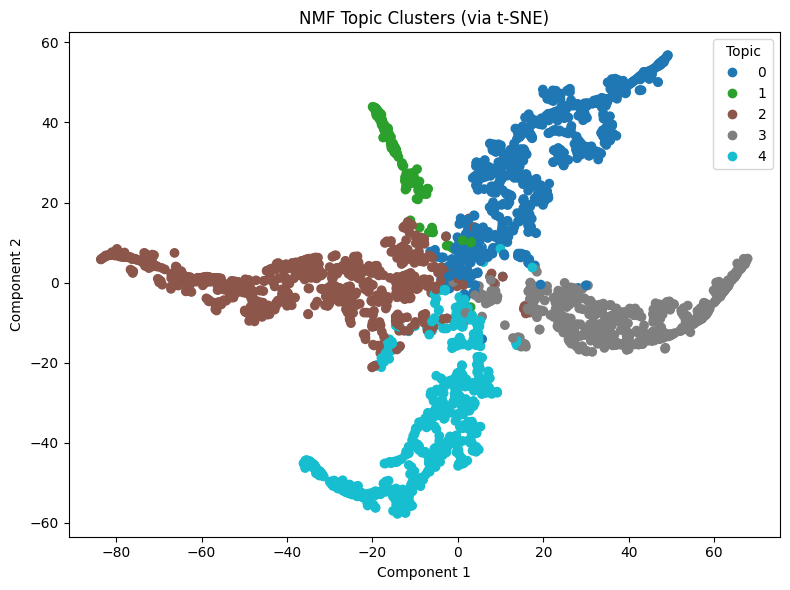

In [19]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_coords_reduced[:, 0], tsne_coords_reduced[:, 1], c=doc_topic_labels_nmf, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Topic")
plt.title("NMF Topic Clusters (via t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

In [20]:
def kmeans_from_scratch(X, k, max_iters=100, tol=1e-4):

    n_docs, n_features = X.shape
    np.random.seed(42)

    # 1. Choosing k random docs as centroids
    init_idxs = np.random.choice(n_docs, size=k, replace=False)
    centroids = X[init_idxs]

    for iteration in tqdm.tqdm(range(max_iters), desc="Converging"):
        # 2. Assign each point to the nearest centroid
        #    compute squared Euclidean distances
        #    shape of dists: (n_docs, k)

        dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)

        labels = np.argmin(dists, axis=1)  # for each sample, index of closest centroid

        # 3. Update centroids as the mean of assigned points
        new_centroids = np.zeros_like(centroids)
        for cluster in range(k):
            members = X[labels == cluster]
            if len(members) > 0:
                new_centroids[cluster] = members.mean(axis=0)
            else:
                # re-initialize empty cluster to a random point
                new_centroids[cluster] = X[np.random.choice(n_docs)]

        # 4. Check for convergence
        centroid_shift = np.linalg.norm(new_centroids - centroids)
        if centroid_shift < tol:
            print()
            print(f"Converged in {iteration} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

k = 5
print("Running on Reduced DTM")
t0 = time.perf_counter()
kmeans_labels_scratch_nmf_reduced, kmeans_centroids_scratch_nmf_reduced = kmeans_from_scratch(
    W,
    k=k,
    max_iters=100,
    tol=1e-4
)
t_scratch_nmf_reduced = time.perf_counter() - t0

# Memory = centroids + maybe distance matrix at peak
mem_scratch_nmf_reduced = memory_bytes(kmeans_centroids_scratch_nmf_reduced)

scores_scratch_nmf_reduced = evaluate(kmeans_labels_scratch_nmf_reduced, W, ground_truth_labels=data.target)

print()
print("Running on Non-Reduced DTM")
t0 = time.perf_counter()
kmeans_labels_scratch, kmeans_centroids_scratch = kmeans_from_scratch(
    dtm_dense,
    k=k,
    max_iters=100,
    tol=1e-4
)
t_scratch = time.perf_counter() - t0

# Memory = centroids + maybe distance matrix at peak
mem_scratch= memory_bytes(kmeans_centroids_scratch)

scores_scratch = evaluate(kmeans_labels_scratch, dtm_dense, ground_truth_labels=data.target)

Running on Reduced DTM


Converging:  15%|█▌        | 15/100 [00:00<00:00, 589.61it/s]



Converged in 15 iterations.

Running on Non-Reduced DTM


Converging:  12%|█▏        | 12/100 [00:11<01:23,  1.05it/s]


Converged in 12 iterations.


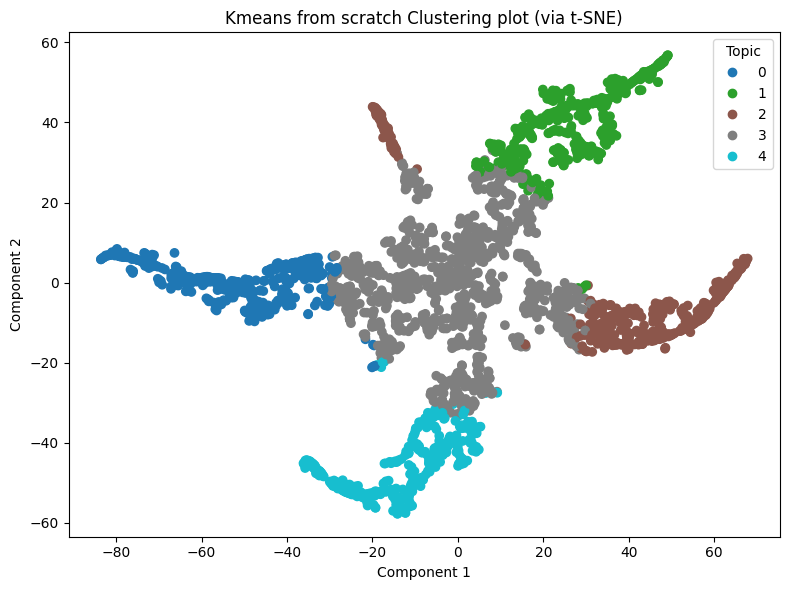

In [21]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_coords_reduced[:, 0], tsne_coords_reduced[:, 1], c=kmeans_labels_scratch_nmf_reduced, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Topic")
plt.title("Kmeans from scratch Clustering plot (via t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

In [22]:
# Scikit-learn Kmeans on NMF-REDUCED data
t0 = time.perf_counter()
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(W)
t_sklearn_nmf_reduced = time.perf_counter() - t0

kmeans_labels_reduced = kmeans.labels_
kmeans_centroids_reduced = kmeans.cluster_centers_

mem_sklearn_nmf_reduced  = memory_bytes(kmeans_centroids_reduced)
scores_sklearn_nmf_reduced  = evaluate(kmeans_labels_reduced, W, ground_truth_labels=data.target)

# Scikit-learn Kmeans on NON-REDUCED data
t0 = time.perf_counter()
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(dtm_dense)
t_sklearn = time.perf_counter() - t0

kmeans_lebels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_

mem_sklearn = memory_bytes(kmeans_centroids)
scores_sklearn = evaluate(kmeans_lebels, dtm_dense, ground_truth_labels=data.target)

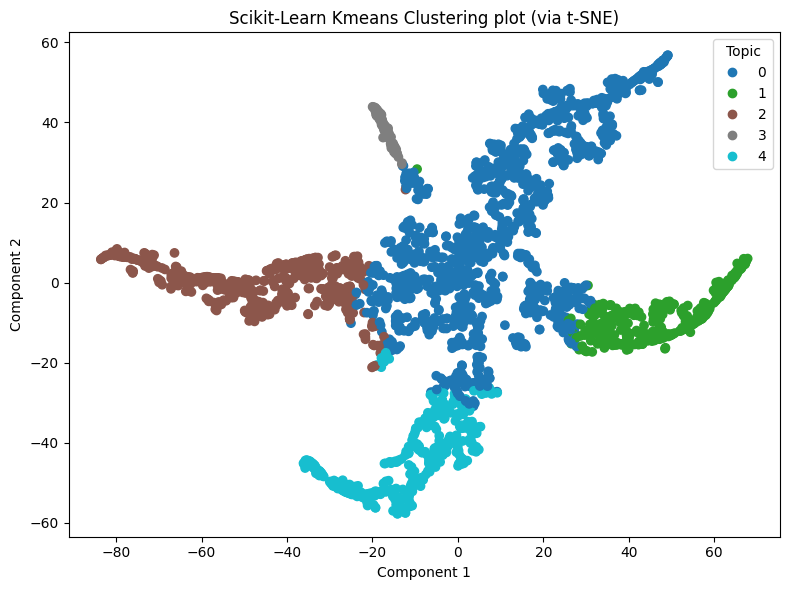

In [23]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_coords_reduced[:, 0], tsne_coords_reduced[:, 1], c=kmeans_labels_reduced, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Topic")
plt.title("Scikit-Learn Kmeans Clustering plot (via t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

In [ ]:
results = []
for name, t, mem, scores in [
    ('NMF',         t_nmf,      mem_nmf,      scores_nmf),
    ('KMeans-SCRATCH-NMF-REDUCED',  t_scratch_nmf_reduced,  mem_scratch_nmf_reduced,  scores_scratch_nmf_reduced),
    ('KMeans-SCRATCH-NON-REDUCED',  t_scratch,  mem_scratch,  scores_scratch),
    ('KMeans-SKL-NMF-REDUCED',  t_sklearn_nmf_reduced,  mem_sklearn_nmf_reduced,  scores_sklearn_nmf_reduced),
    ('KMeans-SKL-NON-REDUCED',  t_sklearn,  mem_sklearn,  scores_sklearn),
]:
    row = {
        'Method': name,
        'Time (s)': round(t, 3),
        'Extra Mem (MB)': round(mem / (1024**2), 2),
        **scores
    }
    results.append(row)

df = pd.DataFrame(results).set_index('Method')
print(df)


                            Time (s)  Extra Mem (MB)       ARI       AMI  \
Method                                                                     
NMF                            0.700            0.39  0.612459  0.640784   
KMeans-SCRATCH-NMF-REDUCED     0.018            0.00  0.383890  0.537124   
KMeans-SCRATCH-NON-REDUCED    10.684            0.29  0.437921  0.531413   
KMeans-SKL-NMF-REDUCED         0.006            0.00  0.384601  0.563715   
KMeans-SKL-NON-REDUCED         2.302            0.29  0.294220  0.490679   

                            Silhouette  
Method                                  
NMF                           0.771835  
KMeans-SCRATCH-NMF-REDUCED    0.340566  
KMeans-SCRATCH-NON-REDUCED    0.015317  
KMeans-SKL-NMF-REDUCED        0.454742  
KMeans-SKL-NON-REDUCED        0.016199  
